# Drilling Activity Prediction: Data Modeling - VARMA

- Load datasets and resample to monthly frequency
- Use oil dataset to make predictions on Oil Rig Count:
    - Get second order differencing data frame (stationary features dataframe) 
    - Train/test split
    - VARMA Model Hyperparameter selection
    - Fit the model
    - Invert Transformation
    - Generate forecast values and plot results
    - Evaluation Metrics
    - Fit the model again but with 100% of the data
    - Forecast real future values


- Use gas dataset to make predictions on Gas Rig Count:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load specific forecasting tools
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tools.eval_measures import rmse, mse, meanabs

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
dfoil = pd.read_csv('dfoil.csv',index_col=0,parse_dates=True)
dfoil = dfoil.resample('M').mean()
dfoil.index.freq = 'M'


dfgas = pd.read_csv('dfgas.csv',index_col=0,parse_dates=True)
dfgas = dfgas.resample('M').mean()
dfgas.index.freq = 'M'

A $K$-dimensional VARMA model of order $(p,q)$ considers each variable $y_K$ in the system.<br>

For example, the system of equations for a 2-dimensional VARMA(1,1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \theta_{11,1}\varepsilon_{1,t-1} + \theta_{12,1}\varepsilon_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \theta_{21,1}\varepsilon_{1,t-1} + \theta_{22,1}\varepsilon_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\theta_{ii,l}$ captures the influence of the $l$th lag of error $\varepsilon_i$ on itself,<br>
the coefficient $\theta_{ij,l}$ captures the influence of the $l$th lag of error $\varepsilon_j$ on $\varepsilon_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are residual white noise.<br>

The order (2,2) is the one that we have been using so far. This means differencing to second level order to guarantee 
stationarity of all features (We used Augmented Dicky Fuller Tests for this).

#### Get second order differencing data frame (stationary features dataframe)

In [3]:
dfoil_transformed = dfoil.diff().diff()
dfoil_transformed = dfoil_transformed.dropna()
dfoil_transformed.head()

,oilrig_count,oil_price,oilconsumption,oilproduction,oilstorage
1997-03-31,-7.056452,1.312871,481.072565,-72.177714,-6540.096313
1997-04-30,-8.104032,0.182258,-152.485198,92.726362,2345.221198
1997-05-31,10.490323,2.344355,424.190083,-43.429157,-3579.112903
1997-06-30,-9.318280,-2.697634,-138.891237,-14.576469,-2234.476344
1997-07-31,3.823656,1.878333,-50.252335,-5.380888,-9928.515054


#### Train/test split

- We will evaluate the model forecasting 12 months ahead (1 year)
- Train test split. Test df will have 12 data points

In [4]:
"""
nobs is the variable that will be used to determine the number of months to predict.
"""

nobs=12
train, test = dfoil_transformed[0:-nobs], dfoil_transformed[-nobs:]

#### Fit VARMA model

In [5]:
oil_model = VARMAX(train, order=(2,2), trend='ct',)
oil_results = oil_model.fit(maxiter=1000, disp=False)
oil_results.summary()

Dep. Variable:,"['oilrig_count', 'oil_price', 'oilconsumption', 'oilproduction', 'oilstorage']",No. Observations:,284
Model:,"VARMA(2,2)",Log Likelihood,-8980.313
,+ intercept,AIC,18210.625
Date:,"Mon, 08 Nov 2021",BIC,18666.747
Time:,10:57:08,HQIC,18393.494
Sample:,03-31-1997,,
,- 10-31-2020,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.15, 0.35, 0.42, 1.05, 1.72",Jarque-Bera (JB):,"1607.50, 69.84, 2593.35, 1546.84, 7.29"
Prob(Q):,"0.70, 0.56, 0.52, 0.30, 0.19",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.03"
Heteroskedasticity (H):,"3.52, 4.13, 2.59, 2.75, 2.08",Skew:,"-1.84, -0.55, -1.89, -1.05, -0.19"


#### Generate Forecast values and plot results

- Create forecasts of differenced dataframe
- Invert dataframe transformation
- Plot results and compare Forecasted values Vs Test set

In [6]:
#12 months forecast
dfoil_forecast = oil_results.forecast(nobs)
dfoil_forecast

,oilrig_count,oil_price,oilconsumption,oilproduction,oilstorage
2020-11-30,-11.915633,-5.725010,-1271.584317,-119.653031,-4064.649221
2020-12-31,-8.077094,3.765860,285.407344,13.394793,-1685.747617
2021-01-31,6.148893,0.174411,18.560477,-28.620932,3975.154291
2021-02-28,4.603573,-0.749598,33.040397,29.439487,78.096593
2021-03-31,2.008062,0.084627,7.088176,-26.194678,-1866.158415
2021-04-30,1.201925,-0.380956,-29.437650,2.210875,-444.446515
2021-05-31,1.466417,-0.071926,6.807925,-8.552008,292.602102
2021-06-30,1.720898,-0.226805,-5.192523,-5.014940,99.623902
2021-07-31,1.765117,-0.087925,5.897516,-6.514849,-214.795117
2021-08-31,1.796187,-0.158076,-1.513073,-5.717476,-205.258957


In [7]:
#Invert dataframe transformation
dfoil_forecast['oilrig_count1d'] = (dfoil['oilrig_count'].iloc[-nobs-1]-dfoil['oilrig_count'].iloc[-nobs-2])+dfoil_forecast['oilrig_count'].cumsum()
dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-nobs-1] + dfoil_forecast['oilrig_count1d'].cumsum()

<AxesSubplot:title={'center':'Oil Rig Count Prediction: FORECAST vs TEST Set'}>

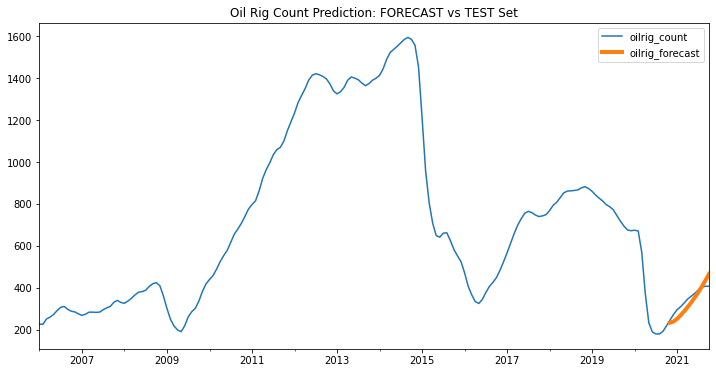

In [8]:
dfoil['oilrig_count'].loc['2006':].plot(figsize=(12,6),legend=True)
dfoil_forecast['oilrig_forecast'].plot(legend=True,linewidth=4,title='Oil Rig Count Prediction: FORECAST vs TEST Set')

#### Evaluation Metrics

In [9]:
RMSE1 = rmse(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])
MSE1 = mse(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])
MAE1 = meanabs(dfoil['oilrig_count'].loc[test.index.min():],dfoil_forecast['oilrig_forecast'])

print(f"""Oil Rig VARMA(2,2) RMSE: {RMSE1:.3f}
Oil Rig VARMA(2,2) MSE: {MSE1:.3f}
Oil Rig VARMA(2,2) MAE: {MAE1:.3f}\n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE1/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%""")

Oil Rig VARMA(2,2) RMSE: 33.603
Oil Rig VARMA(2,2) MSE: 1129.158
Oil Rig VARMA(2,2) MAE: 29.954

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 9.738%


#### Fit Model with 100% of Data and forecast Real Future

In [10]:
oil_model = VARMAX(dfoil_transformed, order=(2,2), trend='ct')
oil_results = oil_model.fit(maxiter=1000, disp=False)
dfoil_forecast = oil_results.forecast(nobs)
# dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-1] + dfoil_forecast['oilrig_count'].cumsum()
dfoil_forecast['oilrig_count1d'] = (dfoil['oilrig_count'].iloc[-1]-dfoil['oilrig_count'].iloc[-2])+dfoil_forecast['oilrig_count'].cumsum()
dfoil_forecast['oilrig_forecast'] = dfoil['oilrig_count'].iloc[-1] + dfoil_forecast['oilrig_count1d'].cumsum()
oil_results.summary()

Dep. Variable:,"['oilrig_count', 'oil_price', 'oilconsumption', 'oilproduction', 'oilstorage']",No. Observations:,296
Model:,"VARMA(2,2)",Log Likelihood,-9416.115
,+ intercept,AIC,19082.230
Date:,"Mon, 08 Nov 2021",BIC,19543.525
Time:,11:00:26,HQIC,19266.923
Sample:,03-31-1997,,
,- 10-31-2021,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"1.10, 0.38, 3.70, 4.03, 0.12",Jarque-Bera (JB):,"1909.85, 64.43, 3276.89, 674.15, 2.46"
Prob(Q):,"0.29, 0.54, 0.05, 0.04, 0.73",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.29"
Heteroskedasticity (H):,"3.40, 3.66, 2.78, 4.50, 2.47",Skew:,"-1.85, -0.50, -1.99, -0.87, -0.03"


<AxesSubplot:title={'center':'Oil Rig Count Prediction: REAL FORECAST'}>

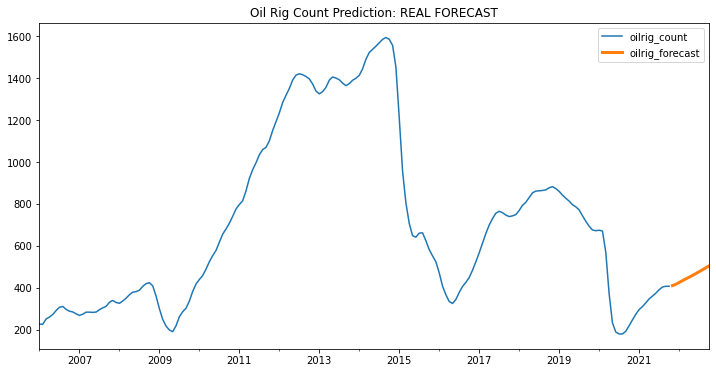

In [11]:
dfoil['oilrig_count'].loc['2006':].plot(figsize=(12,6),legend=True)
dfoil_forecast['oilrig_forecast'].plot(legend=True,linewidth=3,title='Oil Rig Count Prediction: REAL FORECAST')

#### Create model with Gas Rig Counts

In [12]:
dfgas.columns

Index(['gasrig_count', 'gas_price', 'gaswell_count', 'gasimports_amount',
       'gasconsumption_amount'],
      dtype='object')

In [13]:
dfgas_transformed = dfgas.diff().diff()
dfgas_transformed = dfgas_transformed.dropna()

Evaluation Metrics Gas Rig Count VARMA Model:

In [14]:
train, test = dfgas_transformed[0:-nobs], dfoil_transformed[-nobs:]
gas_model = VARMAX(train, order=(2,2),trend='ct')
gas_results = gas_model.fit(maxiter=1000, disp=False)
dfgas_forecast = gas_results.forecast(nobs)
dfgas_forecast['gasrig_count1d'] = (dfgas['gasrig_count'].iloc[-1]-dfgas['gasrig_count'].iloc[-2])+dfgas_forecast['gasrig_count'].cumsum()
dfgas_forecast['gasrig_forecast'] = dfgas['gasrig_count'].iloc[-1] + dfgas_forecast['gasrig_count1d'].cumsum()

<AxesSubplot:title={'center':'Gas Rig Count Prediction: Forecast Vs Test set'}>

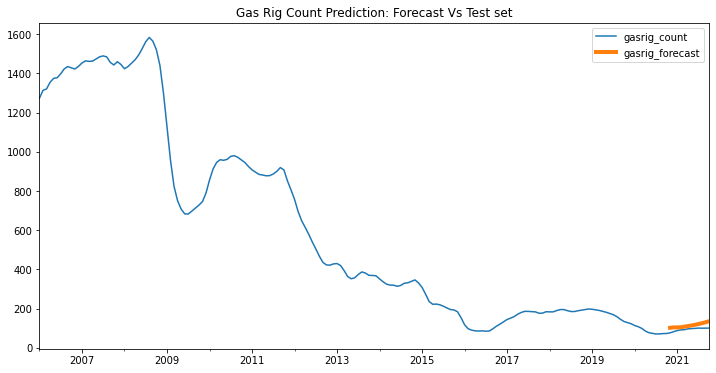

In [15]:
dfgas['gasrig_count'].loc['2006':].plot(figsize=(12,6),legend=True)
dfgas_forecast['gasrig_forecast'].plot(legend=True,linewidth=4,title='Gas Rig Count Prediction: Forecast Vs Test set')

In [16]:
RMSE2 = rmse(dfgas['gasrig_count'].loc[test.index.min():],dfgas_forecast['gasrig_forecast'])
MSE2 = mse(dfgas['gasrig_count'].loc[test.index.min():],dfgas_forecast['gasrig_forecast'])
MAE2 = meanabs(dfgas['gasrig_count'].loc[test.index.min():],dfgas_forecast['gasrig_forecast'])

print(f"""Gas Rig VARMA(2,2) RMSE: {RMSE2:.3f}
Gas Rig VARMA(2,2) MSE: {MSE2:.3f}
Gas Rig VARMA(2,2) MAE: {MAE2:.3f}\n
Gas Rig Mean Value: {dfgas['gasrig_count'][-nobs:].mean():.3f}
Gas Rig std Value: {dfgas['gasrig_count'][-nobs:].std():.3f}
Gas Rig Percent Change: {RMSE2/dfgas['gasrig_count'][-nobs:].mean()*100:.3f}%""")

Gas Rig VARMA(2,2) RMSE: 21.931
Gas Rig VARMA(2,2) MSE: 480.951
Gas Rig VARMA(2,2) MAE: 20.963

Gas Rig Mean Value: 94.254
Gas Rig std Value: 7.984
Gas Rig Percent Change: 23.267%


Forecast Real Future

In [17]:
gas_model = VARMAX(dfgas_transformed, order=(2,2),trend='ct')
gas_results = gas_model.fit(maxiter=1000, disp=False)
dfgas_forecast = gas_results.forecast(nobs)
dfgas_forecast['gasrig_count1d'] = (dfgas['gasrig_count'].iloc[-1]-dfgas['gasrig_count'].iloc[-2])+dfgas_forecast['gasrig_count'].cumsum()
dfgas_forecast['gasrig_forecast'] = dfgas['gasrig_count'].iloc[-1] + dfgas_forecast['gasrig_count1d'].cumsum()

<AxesSubplot:title={'center':'Gas Rig Count Prediction: REAL FORECAST'}>

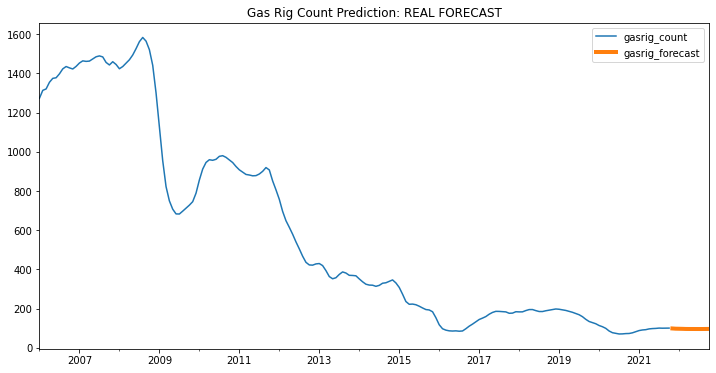

In [18]:
dfgas['gasrig_count'].loc['2006':].plot(figsize=(12,6),legend=True)
dfgas_forecast['gasrig_forecast'].plot(legend=True,linewidth=4,title='Gas Rig Count Prediction: REAL FORECAST')